In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor as xgr 
import pickle
import plotly.express as px


There are some disparities in median costs with respect to carrier, truck type and priority level. Obviously there are some disparities in routes (origin and destination countries) but we already had that covered with the distance which would be more accurate because not all delivery points in a destination country are the same. The same is true for countries of origin.

Therefore, for this test, I will use the following features:

1. distance_km
2. weight_tons
3. carrier_name
4. truck_type
5. priority_level

In [3]:
df = pd.read_csv(r"shipment_costs_10000.csv")

Creating a new dataframe with only the needed column



In [4]:
new_df = df[['distance_km', 'weight_tons', 'carrier_name', 'truck_type', 'priority_level', 'cost_eur']]

scaling distance_km and weight_tons

In [5]:
scaler = StandardScaler(with_std=True)
new_df[['distance_km', 'weight_tons']] = scaler.fit_transform(new_df[['distance_km', 'weight_tons']])
new_df.head()

/var/folders/jh/cmy96w8x08vdjgfkk7pkrvk00000gn/T/ipykernel_68673/3109826584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[['distance_km', 'weight_tons']] = scaler.fit_transform(new_df[['distance_km', 'weight_tons']])


,distance_km,weight_tons,carrier_name,truck_type,priority_level,cost_eur
0,-1.134791,1.275703,DPD,Fridge,Standard,2983.05
1,-1.732409,-0.830532,Maersk,Fridge,Standard,1401.64
2,0.493500,0.258900,Kuehne+Nagel,Box,Standard,3412.53
3,1.626663,1.217600,Maersk,Tautliner,Express,5692.15
4,-0.773911,1.479064,Maersk,Box,Standard,2756.15


In [6]:
with open('scaled_data.pkl', 'wb') as f:
    pickle.dump(scaler, f)

One-hot encoding carrier_name, truck_type, priority_level

In [7]:
encoded_columns = pd.get_dummies(new_df[['carrier_name', 'truck_type', 'priority_level']])

In [8]:
encoded_columns

,carrier_name_DB Schenker,carrier_name_DHL,carrier_name_DPD,carrier_name_Kuehne+Nagel,carrier_name_Maersk,truck_type_Box,truck_type_Fridge,truck_type_Tautliner,priority_level_Express,priority_level_Standard
0,False,False,True,False,False,False,True,False,False,True
1,False,False,False,False,True,False,True,False,False,True
2,False,False,False,True,False,True,False,False,False,True
3,False,False,False,False,True,False,False,True,True,False
4,False,False,False,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
9995,True,False,False,False,False,True,False,False,False,True
9996,False,False,False,True,False,False,True,False,False,True
9997,True,False,False,False,False,False,True,False,True,False
9998,False,False,True,False,False,False,True,False,False,True


In [9]:
with open('encoded_data.pkl', 'wb') as f:
    pickle.dump(encoded_columns, f)

In [10]:
#dropping the encoded columns
new_df.drop(['carrier_name', 'truck_type', 'priority_level'], axis=1, inplace=True)

/var/folders/jh/cmy96w8x08vdjgfkk7pkrvk00000gn/T/ipykernel_68673/984312491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['carrier_name', 'truck_type', 'priority_level'], axis=1, inplace=True)


In [11]:
new_df.head()

,distance_km,weight_tons,cost_eur
0,-1.134791,1.275703,2983.05
1,-1.732409,-0.830532,1401.64
2,0.493500,0.258900,3412.53
3,1.626663,1.217600,5692.15
4,-0.773911,1.479064,2756.15


In [12]:
#concatenating the old dataframe with the dropped columns and the new encoded columns
new_df = pd.concat([new_df, encoded_columns], axis=1)

In [13]:
new_df.head()

,distance_km,weight_tons,cost_eur,carrier_name_DB Schenker,carrier_name_DHL,carrier_name_DPD,carrier_name_Kuehne+Nagel,carrier_name_Maersk,truck_type_Box,truck_type_Fridge,truck_type_Tautliner,priority_level_Express,priority_level_Standard
0,-1.134791,1.275703,2983.05,False,False,True,False,False,False,True,False,False,True
1,-1.732409,-0.830532,1401.64,False,False,False,False,True,False,True,False,False,True
2,0.493500,0.258900,3412.53,False,False,False,True,False,True,False,False,False,True
3,1.626663,1.217600,5692.15,False,False,False,False,True,False,False,True,True,False
4,-0.773911,1.479064,2756.15,False,False,False,False,True,True,False,False,False,True


Splitting dataframe into x and y variables

In [14]:
X_data = new_df.drop(['cost_eur'], axis=1)
y_data = new_df['cost_eur']

Splitting the X and Y data into training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.3, random_state=1)

Building a Linear Regression Model

In [16]:
lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}
model = GridSearchCV(lr, cv=4, param_grid= param_grid)

In [17]:
model.fit(X_train, y_train)

,estimator,LinearRegression()
,param_grid,"{'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [18]:
print(model.best_estimator_)

LinearRegression(positive=True)


In [19]:
model.best_params_

{'fit_intercept': True, 'positive': True}

In [20]:
best_model = model.best_estimator_

In [21]:
lr_yhat = best_model.predict(X_test)

In [22]:
lr_r2_score = r2_score(lr_yhat, y_test)

In [23]:
lr_mse = mean_squared_error(lr_yhat, y_test)

In [24]:
lr_rmse = root_mean_squared_error(lr_yhat, y_test)

Building a KDE Plot of the Actual v Predicted test values

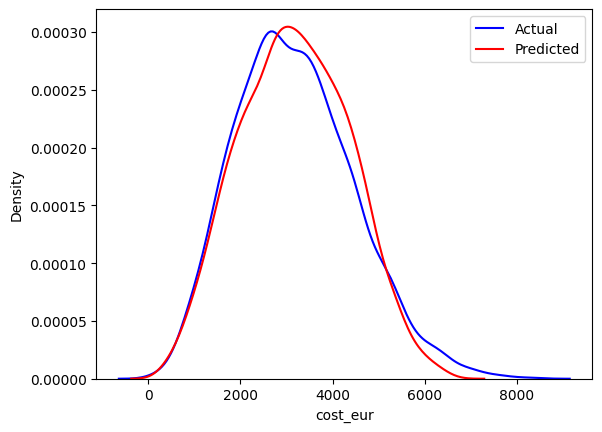

In [25]:
ax1 = sns.kdeplot(y_test, color='blue', )

sns.kdeplot(lr_yhat, color='red', ax=ax1)
plt.legend(['Actual', 'Predicted'])
plt.show()

Building a Ridge Regression Model

In [26]:
ridge_r = Ridge()

param_grid = {'alpha': [10, 1, 0.1, 0.01, 0.001,0.0001]}

ridge_model = GridSearchCV(ridge_r, cv=4, param_grid= param_grid)

In [27]:
ridge_model.fit(X_train, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [10, 1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [28]:
print(ridge_model.best_estimator_)

Ridge(alpha=1)


In [29]:
ridge_best_model = ridge_model.best_estimator_

In [30]:
ridge_yhat = ridge_model.predict(X_test)

In [31]:
ridge_r2 = r2_score(ridge_yhat, y_test)

In [32]:
ridge_mse = mean_squared_error(ridge_yhat, y_test)

In [33]:
ridge_rmse = root_mean_squared_error(ridge_yhat, y_test)

Building a KDE Plot of the Actual v Predicted test values

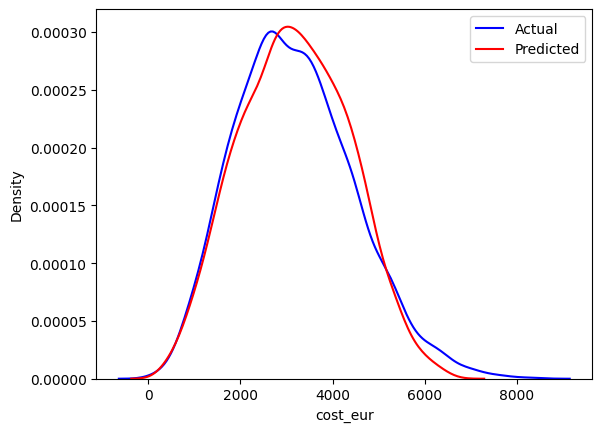

In [34]:
ax1 = sns.kdeplot(y_test, color='blue', )

sns.kdeplot(ridge_yhat, color='red', ax=ax1)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [35]:
print(f'LinearRegression r2_score: {lr_r2_score}')
print(f'ridge_regression r2_score: {ridge_r2}')
print("")
print(f'LinearRegression mse: {lr_mse}')
print(f'ridge_regression mse: {ridge_mse}')
print("")
print(f'LinearRegression rmse: {lr_rmse}')
print(f'ridge_regression rmse: {ridge_rmse}')

LinearRegression r2_score: 0.8481330748454148
ridge_regression r2_score: 0.8480708515281666

LinearRegression mse: 212857.55595774594
ridge_regression mse: 212861.271774982

LinearRegression rmse: 461.3648837501029
ridge_regression rmse: 461.36891071568965


Based on the results, the simple linear regression model is not overfitting because there is no difference between the R2 score of the linear regression model and the ridge regression model

# Using XGBoost Regressor 

In [36]:
xgrn = xgr()

param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01, 1, 10],
    'n_estimator' :[100,150,200]

}

grid = GridSearchCV(
    estimator=xgrn,
    param_grid=param_grid,
    scoring='r2'

)

model_grid = grid.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [19:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [19:58:36] WARNING: /Users/runner

In [37]:
model_grid.best_score_

np.float64(0.8856916289160714)

In [38]:
model_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimator': 100}

In [39]:
best_model_xgr = model_grid.best_estimator_

In [40]:
y_hat_xgr_train = best_model_xgr.predict(X_train)

y_hat_xgr_test = best_model_xgr.predict(X_test)

In [41]:
r2_score_xgr_train = r2_score(y_hat_xgr_train,y_train)
r2_score_xgr_train

0.8840326557146609

In [42]:
r2_score_xgr_test = r2_score(y_hat_xgr_test,y_test)
r2_score_xgr_test

0.8702799410211979

In [43]:
mse_score_xgr_test = mean_squared_error(y_hat_xgr_test,y_test)
mse_score_xgr_test

186858.44230066417

In [44]:
rmse_score_xgr_test = mean_squared_error(y_hat_xgr_test,y_test)
rmse_score_xgr_test = root_mean_squared_error(y_hat_xgr_test, y_test)

In [45]:
print(f'LinearRegression r2_score: {lr_r2_score}')
print(f'ridge_regression r2_score: {ridge_r2}')
print(f"XGB r2_score: {r2_score_xgr_test}")
print("")
print(f'LinearRegression mse: {lr_mse}')
print(f'ridge_regression mse: {ridge_mse}')
print(f"XGB mse: {mse_score_xgr_test}")
print("")
print(f'LinearRegression rmse: {lr_rmse}')
print(f'ridge_regression rmse: {ridge_rmse}')
print(f"XGB rmse: {rmse_score_xgr_test}")

LinearRegression r2_score: 0.8481330748454148
ridge_regression r2_score: 0.8480708515281666
XGB r2_score: 0.8702799410211979

LinearRegression mse: 212857.55595774594
ridge_regression mse: 212861.271774982
XGB mse: 186858.44230066417

LinearRegression rmse: 461.3648837501029
ridge_regression rmse: 461.36891071568965
XGB rmse: 432.2712600910037


In [46]:
print(f'intercept of the model: {best_model_xgr.intercept_}')

intercept of the model: [3177.8289]


In [47]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model_xgr, f)

In [48]:
# Convert all data to float64 to ensure compatibility
import shap 

X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').astype(float)

# Re-run explainer with numeric data
explainer = shap.Explainer(best_model_xgr.predict, X_train_numeric)
shap_values = explainer(X_test_numeric)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 3001it [00:48, 52.12it/s]                          


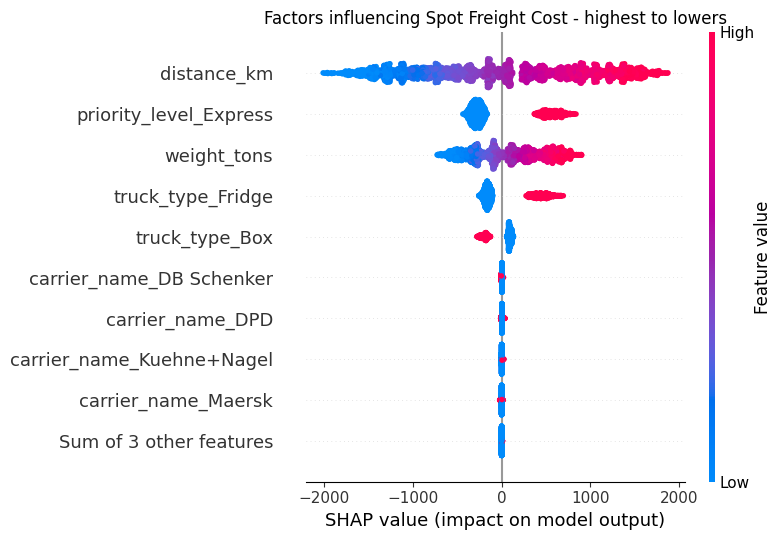

In [ ]:
import matplotlib.pyplot as plt

# Set show=False to prevent immediate plotting
shap.plots.beeswarm(shap_values, show=False)

# Use matplotlib to add the title
plt.title("Factors influencing Spot Freight Cost - highest to lowest")
plt.tight_layout()
plt.show()

In [50]:
X_train_numeric.to_csv(r'x_train_numeric.csv', index=False)
X_test_numeric.to_csv(r'x_test_numeric.csv', index=False)

Conclusion:

This notebook as answered fundamental questions about the company's logistical costs and built a linear regression model that predicts the cost transporting goods. The model explains 84% of the variance in the target variable. This model will serve as a guide for Spot Freights and makes accomodation for flexibilty and intuitive human decision making